In [2]:
import struct
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import os

In [3]:
class MnistDataloader:
    def __init__(self):
        pass

    def read_images_labels(self, img_fp, lbl_fp):
        with open(lbl_fp, 'rb') as f:
            magic, num = struct.unpack(">II", f.read(8))
            assert magic == 2049, "Invalid label file"
            labels = np.frombuffer(f.read(), dtype=np.uint8)
        with open(img_fp, 'rb') as f:
            magic, num2, rows, cols = struct.unpack(">IIII", f.read(16))
            assert magic == 2051, "Invalid image file"
            data = np.frombuffer(f.read(), dtype=np.uint8)
        images = data.reshape(num2, rows * cols)
        return images, labels

    def load_data(self, train_img, train_lbl, test_img, test_lbl):
        xtr, ytr = self.read_images_labels(train_img, train_lbl)
        xte, yte = self.read_images_labels(test_img, test_lbl)
        return (xtr, ytr), (xte, yte)
    

    
train_img = r"train-images.idx3-ubyte"
train_lbl = r"train-labels.idx1-ubyte"
test_img = r"t10k-images.idx3-ubyte"
test_lbl = r"t10k-labels.idx1-ubyte"

(X_full, y_full), (X_test_full, y_test_full) = MnistDataloader().load_data(train_img, train_lbl, test_img, test_lbl)


In [4]:
mask_train = np.isin(y_full, [0,1])
mask_test = np.isin(y_test_full, [0,1])
X_tr, y_tr = X_full[mask_train], y_full[mask_train]
X_te, y_te = X_test_full[mask_test], y_test_full[mask_test]

np.random.seed(79)  

ind = []
for i in [0, 1]:
    i_ind = np.where(y_tr == i)[0]
    np.random.shuffle(i_ind)
    ind.append(i_ind[:1000])


idx = np.hstack(ind)
np.random.shuffle(idx)


cut = int(len(idx) * 0.8)   # 80% for training, 20% for validation
X_train = X_tr[idx[:cut]]
Y_train = y_tr[idx[:cut]]
X_val = X_tr[idx[cut:]]
y_val = y_tr[idx[cut:]]

In [5]:
def PCA(X_train, X_val, X_test, n_components=5):
    mean = X_train.mean(axis=0)
    Xc = X_train - mean
    cov = np.cov(Xc, rowvar=False)
    vals, vecs = np.linalg.eigh(cov)
    top = vecs[:, np.argsort(vals)[::-1][:n_components]]
    return Xc.dot(top), (X_val - mean).dot(top), (X_test - mean).dot(top)

In [ ]:
 
X_train_PCA, X_val_PCA, X_test_PCA = PCA(X_train, X_val, X_te, n_components=5)


y_train_PCA  = np.where(Y_train  == 1, 1, -1)
y_val_PCA = np.where(y_val == 1, 1, -1)
y_test_PCA  = np.where(y_te == 1, 1, -1)




In [ ]:
def predict_stump(X, feature, threshold, left_label, right_label):
    return np.where(X[:, feature] <= threshold, left_label, right_label)


def get_best_stump(X, y, w, cuts):
    n, d = X.shape
    error = np.inf
    ans = None
    for j in range(d):
        for thr in cuts[j]:

            pred = np.where(X[:, j] <= thr, 1, -1)
            err = np.sum(w * (pred != y))

            err_inv = np.sum(w * (pred == y))
            if err_inv < err:
                err, lp, rp = err_inv, -1, 1
            else:
                lp, rp = 1, -1
            if err < error:
                error = err
                ans = (j, thr, lp, rp)
                
    feature, threshold, left_label, right_label = ans
    return feature, threshold, left_label, right_label, error

def compute_beta(err):
    eps = 1e-10  # small number to avoid log(0)
    err = np.clip(err, eps, 1 - eps)  
    return 0.5 * np.log((1 - err) / err)



def update_weights(w, beta, y, pred):
    w = w * np.exp(-beta * y * pred)
    return w / w.sum()

In [15]:

def adaboost(X_train, y_train, X_val, y_val, X_test, y_test, rounds, num_cuts=3):
   
    n, d = X_train.shape
    w = np.ones(n) / n  # initialize weights

    cuts = [
        np.linspace(X_train[:, j].min(), X_train[:, j].max(), num_cuts + 2)[1:-1]
        for j in range(d)
    ]


    F_tr = np.zeros(n)
    F_val = np.zeros(len(y_val)) if X_val is not None else None
    F_te = np.zeros(len(y_test))

    train_loss, val_loss, test_loss, train_error,stumps = [], [], [], [],[]

    for t in range(rounds):
        # fit best stump
        f, thr, lp, rp, err = get_best_stump(X_train, y_train, w, cuts)
        beta = compute_beta(err)
        pred_tr = predict_stump(X_train, f, thr, lp, rp)    # predict training set
        w = update_weights(w, beta, y_train, pred_tr)       # update weights
        print (w)


        F_tr += beta * pred_tr
        F_val += beta * predict_stump(X_val, f, thr, lp, rp)
        F_te += beta * predict_stump(X_test, f, thr, lp, rp)

        
        tr_err = np.mean(np.sign(F_tr) != y_train)
        te_err = np.mean(np.sign(F_te) != y_test)
        train_error.append(tr_err)     
        train_loss.append(tr_err)       
        test_loss.append(te_err)       
                    
        va_err = np.mean(np.sign(F_val) != y_val)
        val_loss.append(va_err)
        stumps.append( (f, thr, lp, rp, beta) )


    return train_loss, val_loss, test_loss, train_error,stumps


In [16]:
train_loss, val_loss, test_loss, train_error,stumps = adaboost(X_train_PCA, y_train_PCA, X_val_PCA, y_val_PCA, X_test_PCA, y_test_PCA, rounds=100, num_cuts=3)


[0.00031348 0.00031348 0.00031348 ... 0.00031348 0.00031348 0.00031348]
[0.00018369 0.00106838 0.00018369 ... 0.00018369 0.00018369 0.00106838]
[0.00048243 0.0006598  0.00048243 ... 0.00011344 0.00011344 0.0006598 ]
[3.11295941e-04 4.25748277e-04 3.11295941e-04 ... 7.31999243e-05
 2.51946833e-04 1.46538307e-03]
[2.18066761e-04 2.98242076e-04 2.18066761e-04 ... 5.12774767e-05
 1.76491956e-04 1.02651946e-03]
[1.70243300e-04 4.14750709e-04 1.70243300e-04 ... 4.00319922e-05
 1.37786121e-04 1.42753054e-03]
[1.21495791e-04 2.95990886e-04 1.21495791e-04 ... 6.68568172e-05
 2.30114491e-04 1.01877109e-03]
[2.06892134e-04 2.09512830e-04 2.06892134e-04 ... 4.73236226e-05
 1.62883185e-04 7.21122248e-04]
[1.55918746e-04 3.11276064e-04 3.07382460e-04 ... 3.56641875e-05
 1.22752573e-04 1.07138114e-03]
[1.16477327e-04 2.32535246e-04 2.29626574e-04 ... 5.39238040e-05
 1.85600351e-04 8.00363106e-04]
[8.92712609e-05 3.34466277e-04 1.75991794e-04 ... 4.13286096e-05
 1.42248949e-04 1.15119954e-03]
[6.75521

In [17]:
print("Final Classifier:")
for i, (feature, threshold, left_label, right_label, beta) in enumerate(stumps):
    print(f"Round {i+1}: Feature {feature}, Threshold {threshold:.4f}, Left {left_label}, Right {right_label}, Beta {beta:.4f}")


Final Classifier:
Round 1: Feature 0, Threshold 313.9567, Left -1, Right 1, Beta 2.8826
Round 2: Feature 0, Threshold -545.1086, Left -1, Right 1, Beta 0.8803
Round 3: Feature 1, Threshold -117.8399, Left -1, Right 1, Beta 0.7238
Round 4: Feature 2, Threshold -486.1218, Left 1, Right -1, Beta 0.6180
Round 5: Feature 0, Threshold 313.9567, Left -1, Right 1, Beta 0.4569
Round 6: Feature 0, Threshold -545.1086, Left -1, Right 1, Beta 0.2887
Round 7: Feature 2, Threshold 543.8489, Left -1, Right 1, Beta 0.4251
Round 8: Feature 1, Threshold -117.8399, Left -1, Right 1, Beta 0.4389
Round 9: Feature 1, Threshold 605.5920, Left 1, Right -1, Beta 0.3394
Round 10: Feature 2, Threshold 543.8489, Left -1, Right 1, Beta 0.3525
Round 11: Feature 0, Threshold -545.1086, Left -1, Right 1, Beta 0.3148
Round 12: Feature 2, Threshold -486.1218, Left 1, Right -1, Beta 0.3333
Round 13: Feature 3, Threshold -703.0038, Left -1, Right 1, Beta 0.2371
Round 14: Feature 4, Threshold -288.2968, Left 1, Right -1, 

In [18]:
def final_classifier(x, stumps):
    final_sum = 0
    for stump in stumps:
        feature_idx = stump['feature_index']
        threshold = stump['threshold']
        left_pred = stump['left_prediction']
        right_pred = stump['right_prediction']
        beta = stump['beta']

        pred = left_pred if x[feature_idx] <= threshold else right_pred
        final_sum += beta * pred

    return np.sign(final_sum)


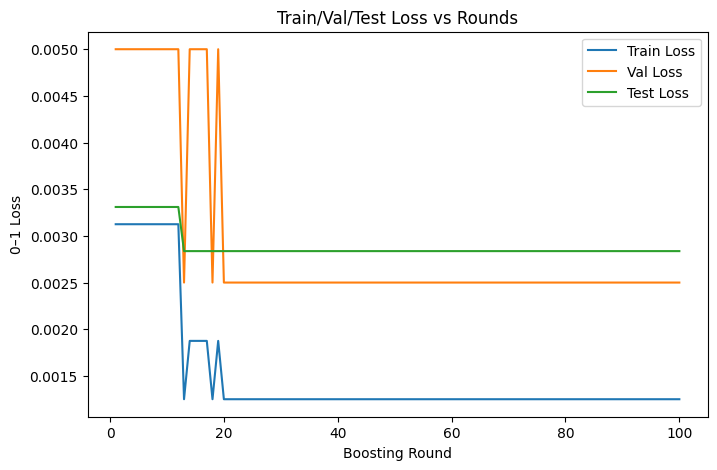

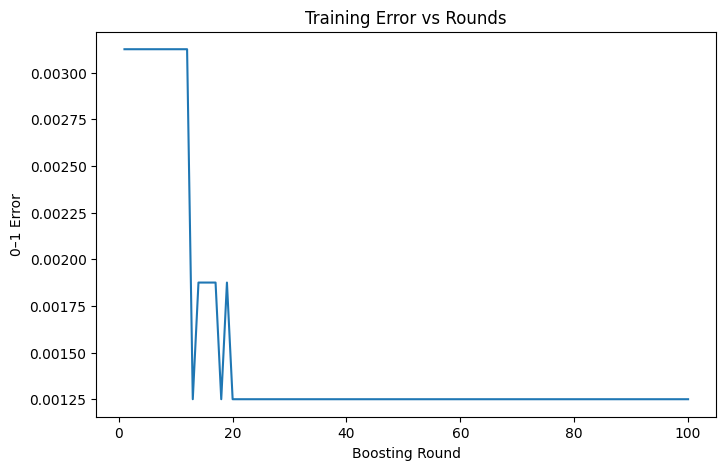

Final Test Accuracy: 0.9972


In [19]:

rounds = np.arange(1, len(train_loss) + 1)

plt.figure(figsize=(8,5))
plt.plot(rounds, train_loss, label="Train Loss")
plt.plot(rounds, val_loss,   label="Val Loss")
plt.plot(rounds, test_loss,  label="Test Loss")
plt.xlabel("Boosting Round")
plt.ylabel("0–1 Loss")
plt.title("Train/Val/Test Loss vs Rounds")
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(rounds, train_error, label="Train Error")
plt.xlabel("Boosting Round")
plt.ylabel("0–1 Error")
plt.title("Training Error vs Rounds")
plt.show()


print(f"Final Test Accuracy: {1 - test_loss[-1]:.4f}")